In [83]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

### Downloading data
Download the data from here:
https://www.kaggle.com/datasets/raviiloveyou/predict-taxi-fare-with-a-bigquery-ml-forecasting?resource=download

Initial Data Preparation

In [2]:
df = pd.read_csv('taxi_fare\\train.csv')

In [3]:
df.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0


As we can see all features names are small caps and with no space in between

In [4]:
df.shape

(209673, 8)

### Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       209673 non-null  float64
 1   distance_traveled   209673 non-null  float64
 2   num_of_passengers   209673 non-null  float64
 3   fare                209673 non-null  float64
 4   tip                 209673 non-null  int64  
 5   miscellaneous_fees  209673 non-null  float64
 6   total_fare          209673 non-null  float64
 7   surge_applied       209673 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 12.8 MB


No categorical columns found

Dataset :

⏱️ 'trip_duration': How long did the journey last?[in Seconds]

🛣️ 'distance_traveled': How far did the taxi travel?[in Km]

🧑‍🤝‍🧑 'num_of_passengers': How many passengers were in the taxi?

💵 'fare': What's the base fare for the journey?(this is your prediction target!)[In INR]

💲 'tip': How much did the driver receive in tips?[In INR]

🎀 'miscellaneous_fees': Were there any additional charges during the trip?e.g. tolls, convenience fees, GST
etc.[In INR]

💰 'total_fare': The grand total for the ride. It's the sum of fare, tip and miscellaneous_fees[In INR]

⚡ 'surge_applied': Was there a surge pricing applied? Yes or no?

In [6]:
#Checking for Null Values 

df.isnull().sum()

trip_duration         0
distance_traveled     0
num_of_passengers     0
fare                  0
tip                   0
miscellaneous_fees    0
total_fare            0
surge_applied         0
dtype: int64

No Null Values were found

In [7]:
df.columns

Index(['trip_duration', 'distance_traveled', 'num_of_passengers', 'fare',
       'tip', 'miscellaneous_fees', 'total_fare', 'surge_applied'],
      dtype='object')

In [8]:
df.shape

(209673, 8)

In [9]:
#Checking for Duplicate Records
#df[df.duplicated(keep=False)].to_excel('duplicated.xlsx',index=True)
df.duplicated().sum()

4325

In [10]:
#Dropping duplicated records
df.drop_duplicates(inplace=True)

In [11]:
df.shape

(205348, 8)

In [12]:
numerical = list(df.columns[df.dtypes != "object"])

In [13]:
df[numerical].describe()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
count,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000,205348.000000
mean,1189.102226,5.123167,1.298654,100.656568,13.247560,15.294384,129.198512,0.285803
std,4824.302160,126.528223,0.939258,86.142902,20.507879,12.621609,99.283531,0.451797
min,0.000000,0.020000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.000000
25%,454.000000,1.980000,1.000000,52.500000,0.000000,6.000000,73.125000,0.000000
50%,716.000000,3.250000,1.000000,78.750000,9.000000,9.750000,103.500000,0.000000
75%,1110.000000,5.810000,1.000000,116.250000,20.000000,26.525000,153.450000,1.000000
max,86387.000000,57283.910000,9.000000,4466.250000,2500.000000,435.000000,4472.250000,1.000000



- Removing where fare = 0, cause it seems wrong

In [36]:
df[df['fare']==0]

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
2385,82.0,0.16,1.0,0.0,0,0.000,0
2389,588.0,2.41,1.0,0.0,0,0.000,0
6311,2591.0,19.96,2.0,0.0,0,49.125,0
6706,1330.0,5.15,1.0,0.0,0,0.000,0
7467,3669.0,8.37,3.0,0.0,0,0.000,0
...,...,...,...,...,...,...,...
201515,3796.0,17.70,1.0,0.0,0,0.000,0
201900,5259.0,39.75,2.0,0.0,0,0.000,0
204870,27.0,0.16,1.0,0.0,0,0.000,0
205775,3762.0,24.94,1.0,0.0,0,49.125,0


In [37]:
df = df[df['fare']!=0]

In [38]:
df.shape

(205197, 7)

Plots

In [51]:
df.columns

Index(['trip_duration', 'distance_traveled', 'num_of_passengers', 'fare',
       'tip', 'miscellaneous_fees', 'surge_applied'],
      dtype='object')

array([<Axes: xlabel='surge_applied', ylabel='fare'>], dtype=object)

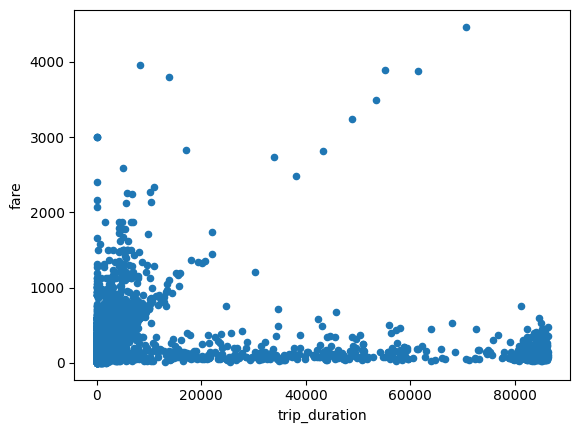

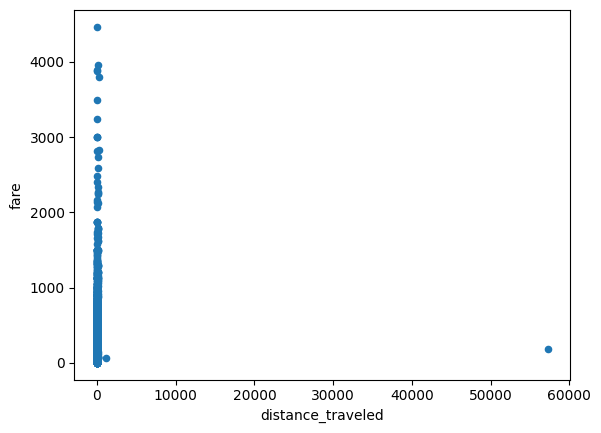

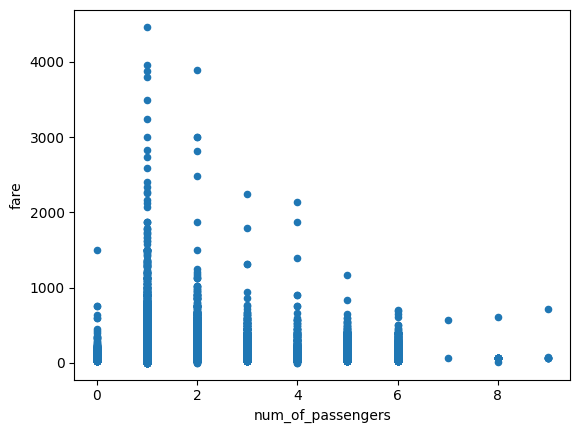

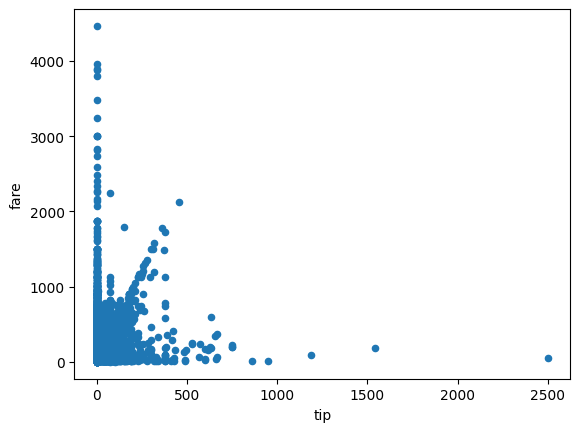

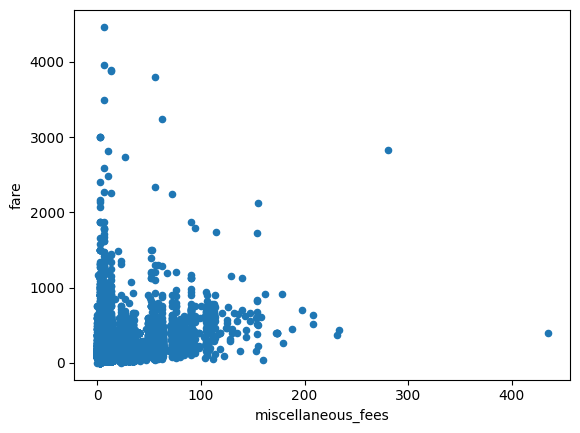

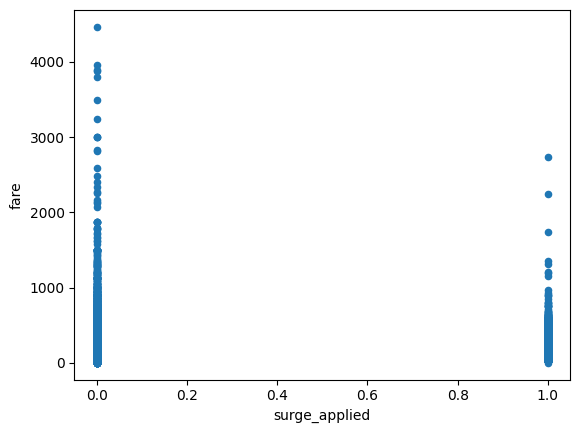

In [56]:
# Scatter plots
df.plot.scatter(x="trip_duration", y="fare", subplots=True)
df.plot.scatter(x="distance_traveled", y="fare", subplots=True)
df.plot.scatter(x="num_of_passengers", y="fare", subplots=True)
df.plot.scatter(x="tip", y="fare", subplots=True)
df.plot.scatter(x="miscellaneous_fees", y="fare", subplots=True)
df.plot.scatter(x="surge_applied", y="fare", subplots=True)

### Analysing discrepancies

In [61]:
# Analysing discrepancies
max = df["miscellaneous_fees"].max()
df[df["miscellaneous_fees"] == max]

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
192514,2451.0,24.17,1.0,390.0,165,435.0,0


In [62]:
max = df["tip"].max()
df[df["tip"] == max]

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
178320,420.0,2.24,6.0,52.5,2500,30.35,1


In [75]:
max = df["distance_traveled"].max()
df[df["distance_traveled"] == max]

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
197339,1734.0,57283.91,1.0,187.125,20,50.875,0


In [160]:
#max_num = df[df["distance_traveled"] == df["distance_traveled"].max()].index
#df.loc[max_num]

The distance travel looks not accurate so it will be removed.

In [74]:
df.loc[197339]

trip_duration          1734.000
distance_traveled     57283.910
num_of_passengers         1.000
fare                    187.125
tip                      20.000
miscellaneous_fees       50.875
surge_applied             0.000
Name: 197339, dtype: float64

In [76]:
df.drop([197339], axis=0, inplace=True)

In [77]:
df.shape

(205196, 7)

Correlation 

In [31]:
df_cor = df[numerical].corrwith(df.fare).to_frame('Correlation')

In [32]:
df_cor.sort_values(by='Correlation', ascending=False)

,Correlation
fare,1.000000
total_fare,0.966613
tip,0.297851
miscellaneous_fees,0.294539
trip_duration,0.148904
surge_applied,0.140779
distance_traveled,0.035740
num_of_passengers,0.009699


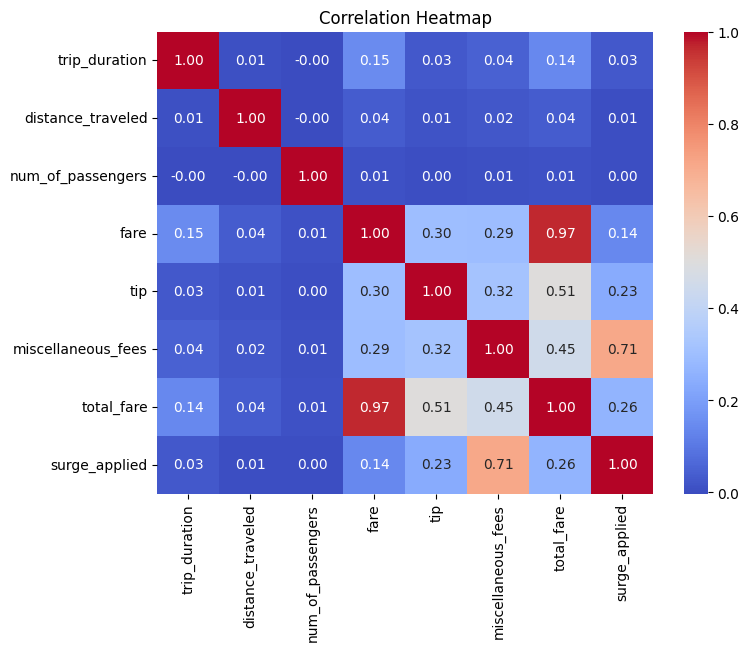

In [30]:
# Create a heatmap
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(df[numerical].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


As total_fare is directly dependent of fare, I'll remove total fare column

In [34]:
df.drop(['total_fare'], axis=1, inplace=True)

In [35]:
df.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,0
2,730.0,3.12,1.0,71.25,0,26.625,1
3,671.0,5.63,3.0,90.00,0,9.750,0
4,329.0,2.09,1.0,45.00,12,13.200,0


## Preparing the Train and Test datasets

In [80]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fare.values
y_val = df_val.fare.values
y_test = df_test.fare.values

del df_train['fare']
del df_val['fare']
del df_test['fare']

In [81]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [82]:
test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

### Model 1 - linear regression:

In [86]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [88]:
r_sq = model.score(X_val, y_val)
print(f"coefficient of determination: {r_sq}")


print(f"intercept: {model.intercept_}")


print(f"coefficients: {model.coef_}")


coefficient of determination: 0.7206154360875706
intercept: 33.749568018222604
coefficients: [ 1.41006580e+01 -4.80977185e-01  3.50792702e-01  7.07401486e+00
  2.10514896e-01  7.97385745e-04]


In [89]:
val_dict = df_val.to_dict(orient='records')


In [90]:
y_pred = model.predict(X_val)

In [91]:
y_pred

array([210.72128103, 244.35676577,  62.99997136, ..., 186.68289947,
        44.7441805 ,  93.45101346])

In [98]:
(y_val - (y_pred)).mean()

-0.18600157805067286

In [107]:
rmse = np.sqrt(mean_squared_error(y_val,y_pred))
rmse

42.87861814228884

K-fold evaluation

In [112]:
# DEFINING TRAIN AND PREDICT FUNCTION:
def train(df_train, y_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LinearRegression()
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)

    return y_pred

In [113]:
from sklearn.model_selection import KFold

In [122]:
# INITIALIZING KFOLD CROSS VALIDATION:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.fare
    y_val = df_val.fare

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    #auc = roc_auc_score(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val,y_pred))
    scores.append(rmse)
    print(rmse)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

4.819723460213458e-12
5.09150960199402e-12
5.8870710408220176e-12
5.365130539202486e-12
4.106439179898148e-12
0.000 +- 0.000


- The k-fold created a overfited model

### Model 2 - Decision tree:

In [123]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fare.values
y_val = df_val.fare.values
y_test = df_test.fare.values

del df_train['fare']
del df_val['fare']
del df_test['fare']

In [124]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [125]:
y_pred = dt.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

60.277772806638104

Tunning the Decision Tree model

In [126]:
# checking best Max Depth
for depth in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, None]:
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('%4s -> %.3f' % (depth, rmse))

   1 -> 60.957


   2 -> 49.638
   3 -> 44.337
   4 -> 40.295
   5 -> 39.471
   6 -> 38.619
   7 -> 42.560
   8 -> 55.972
   9 -> 56.497
  10 -> 57.078
  15 -> 60.307
  20 -> 61.618
None -> 60.435


- Max depth = 6 have the Best Score, so I'll use it

In [129]:
#Checking num of leafs
m=6
print('depth: %s' % m)

for s in [1, 5, 10, 15, 20, 50, 100, 200]:
    dt = DecisionTreeRegressor(max_depth=m, min_samples_leaf=s)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('min_leafs %4s -> %.3f' % (s, rmse))
    


depth: 6


min_leafs    1 -> 38.619
min_leafs    5 -> 37.553
min_leafs   10 -> 37.347
min_leafs   15 -> 37.467
min_leafs   20 -> 37.551
min_leafs   50 -> 37.473
min_leafs  100 -> 37.607
min_leafs  200 -> 38.068


- The best parameter observed are Max_depth = 6 and min_samples_leaf= 10

In [131]:
#Computing Final RMSE
dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=10)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)

rmse_dt = np.sqrt(mean_squared_error(y_val, y_pred))
print(round(rmse_dt,3))

37.347


### Model 3 - Random Forest

In [132]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fare.values
y_val = df_val.fare.values
y_test = df_test.fare.values

del df_train['fare']
del df_val['fare']
del df_test['fare']

In [134]:
rf = RandomForestRegressor(n_estimators=6)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

38.684269778696475

Tunning the Random Forest Regressor

In [135]:
#Number of estimators

for i in tqdm(range(1, 21, 1)):
    rf = RandomForestRegressor(n_estimators=i, n_jobs=-1, warm_start=True, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('n_estimators %s -> %.3f' % (i, rmse))
    

  5%|▌         | 1/20 [00:02<00:53,  2.81s/it]

n_estimators 1 -> 46.349


 10%|█         | 2/20 [00:04<00:42,  2.38s/it]

n_estimators 2 -> 42.063


 15%|█▌        | 3/20 [00:08<00:46,  2.74s/it]

n_estimators 3 -> 39.693


 20%|██        | 4/20 [00:11<00:47,  2.99s/it]

n_estimators 4 -> 38.636


 25%|██▌       | 5/20 [00:16<00:53,  3.58s/it]

n_estimators 5 -> 38.719


 30%|███       | 6/20 [00:21<00:57,  4.13s/it]

n_estimators 6 -> 39.250


 35%|███▌      | 7/20 [00:26<00:58,  4.46s/it]

n_estimators 7 -> 38.309


 40%|████      | 8/20 [00:31<00:57,  4.81s/it]

n_estimators 8 -> 37.849


 45%|████▌     | 9/20 [00:39<01:02,  5.65s/it]

n_estimators 9 -> 37.658


 50%|█████     | 10/20 [00:47<01:04,  6.42s/it]

n_estimators 10 -> 38.058


 55%|█████▌    | 11/20 [00:55<01:01,  6.78s/it]

n_estimators 11 -> 38.119


 60%|██████    | 12/20 [01:05<01:01,  7.73s/it]

n_estimators 12 -> 37.846


 65%|██████▌   | 13/20 [01:15<00:58,  8.40s/it]

n_estimators 13 -> 37.764


 70%|███████   | 14/20 [01:25<00:53,  8.89s/it]

n_estimators 14 -> 37.491


 75%|███████▌  | 15/20 [01:34<00:45,  9.11s/it]

n_estimators 15 -> 37.431


 80%|████████  | 16/20 [01:45<00:39,  9.76s/it]

n_estimators 16 -> 37.512


 85%|████████▌ | 17/20 [01:58<00:31, 10.66s/it]

n_estimators 17 -> 37.536


 90%|█████████ | 18/20 [02:11<00:22, 11.31s/it]

n_estimators 18 -> 37.717


 95%|█████████▌| 19/20 [02:24<00:11, 11.91s/it]

n_estimators 19 -> 37.851


100%|██████████| 20/20 [02:38<00:00,  7.94s/it]

n_estimators 20 -> 37.751


In [139]:
#Number of estimators
rmse_array = []

for i in tqdm(range(1, 51, 1)):
    rf = RandomForestRegressor(n_estimators=i, n_jobs=-1, warm_start=True, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    #print('n_estimators %s -> %.3f' % (i, rmse))
    rmse_array.append(rmse)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [12:12<00:00, 14.66s/it]


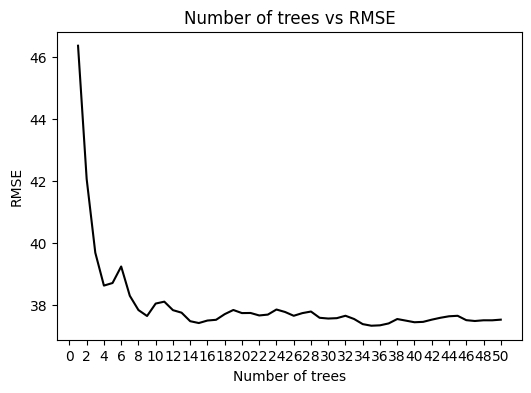

In [140]:
plt.figure(figsize=(6, 4))

plt.plot(range(1, 51, 1), rmse_array, color='black')
plt.xticks(range(0, 51, 2))

plt.title('Number of trees vs RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')

# plt.savefig('ch06-figures/06_random_forest_n_estimators.svg')

plt.show()

In [144]:
rmse_array[35]

37.35782082136784

- Best result for n_estimators is 35

In [146]:
# Max_depth parameter

for depth in range(10, 21):
    print('depth: %s' % depth)
    rf = RandomForestRegressor(n_estimators=35, max_depth=depth, random_state=1, n_jobs=-1, warm_start=True)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('n_estimators=35 -> %.3f' % rmse)

depth: 10


n_estimators=35 -> 36.594
depth: 11
n_estimators=35 -> 36.494
depth: 12
n_estimators=35 -> 36.449
depth: 13
n_estimators=35 -> 36.785
depth: 14
n_estimators=35 -> 36.871
depth: 15
n_estimators=35 -> 36.957
depth: 16
n_estimators=35 -> 37.146
depth: 17
n_estimators=35 -> 37.223
depth: 18
n_estimators=35 -> 37.133
depth: 19
n_estimators=35 -> 37.482
depth: 20
n_estimators=35 -> 37.527


- Best result for max_depth parameter is 12

In [149]:
# Min sample leafs

for m in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200]:
    
    rf = RandomForestRegressor(n_estimators=35, max_depth=12, min_samples_leaf=m, random_state=1, n_jobs=-1, warm_start=True)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('min_samples_leaf=%s -> %.3f' % (m, rmse))

min_samples_leaf=1 -> 36.449
min_samples_leaf=2 -> 34.821
min_samples_leaf=3 -> 34.786
min_samples_leaf=4 -> 35.071
min_samples_leaf=5 -> 35.223
min_samples_leaf=6 -> 35.160
min_samples_leaf=7 -> 35.125
min_samples_leaf=8 -> 35.180
min_samples_leaf=9 -> 35.186
min_samples_leaf=10 -> 35.181
min_samples_leaf=50 -> 35.387
min_samples_leaf=100 -> 36.398
min_samples_leaf=200 -> 38.016


- The best parameters observed are n_estimators=35, max_depth=12, min_samples_leaf=3

In [151]:
#Computing Final RMSE
rf = RandomForestRegressor(n_estimators=35, max_depth=12, min_samples_leaf=3, random_state=1, n_jobs=-1, warm_start=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse_rf)

34.78625410918454


## The best model is Random Forest Regressor with best lower RMSE